# Providing insights from self-reported sexism data

This notebook analyses a dataset of sexism stories entries that has a 'workplace' tag. 
The timeline of the entries in the dataset ranged from Sep 2019 to Sep 2022.

In [1]:
# Imports for data reading and visualisation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('../workplace_veryday_sexism_data_1_78.csv')  

Let's get an idea of the total entries and if there are any missing data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   770 non-null    int64 
 1   post_id      770 non-null    object
 2   tags         770 non-null    object
 3   title        769 non-null    object
 4   date         770 non-null    object
 5   description  770 non-null    object
dtypes: int64(1), object(5)
memory usage: 36.2+ KB


Summary: The CSV file contained 770 entries of sexual harassment stories (from 21 Sep 2019 to 21 Sep 2022) that contained 'workplace' tag.

In [4]:
df.head()

,Unnamed: 0,post_id,tags,title,date,description
0,0,post-199274,"['university', 'workplace']",Kayte,21st September 2022,"Hello Laura, Thank you so much for creating a ..."
1,1,post-199279,"['cuerpo', 'workplace']",María,21st September 2022,El director de la Biblioteca donde trabajo men...
2,2,post-199285,"['conferences', 'engineering', 'webinars', 'wo...",A disappointed professional engineer,21st September 2022,"Since lockdowns began over a year ago, I have ..."
3,3,post-199299,['workplace'],Joy,21st September 2022,I work in a library and seeing what passes for...
4,4,post-199308,['workplace'],Lori,21st September 2022,Nothing quite like the review of being “hard t...


Looks like there may be some non-English text. After a manual inspection, only entry 1 is non-English text. We shall drop that entry. 

In [5]:
df = df.drop(1, axis=0)
df.reset_index(drop=True, inplace=True)
df.head()

,Unnamed: 0,post_id,tags,title,date,description
0,0,post-199274,"['university', 'workplace']",Kayte,21st September 2022,"Hello Laura, Thank you so much for creating a ..."
1,2,post-199285,"['conferences', 'engineering', 'webinars', 'wo...",A disappointed professional engineer,21st September 2022,"Since lockdowns began over a year ago, I have ..."
2,3,post-199299,['workplace'],Joy,21st September 2022,I work in a library and seeing what passes for...
3,4,post-199308,['workplace'],Lori,21st September 2022,Nothing quite like the review of being “hard t...
4,5,post-199309,['workplace'],Liza,21st September 2022,I’m a finance manager – oversee millions of do...


Let's drop the title, as this matched the entry field for person's name in the submission form.

In [6]:
# drop the title row as this matched the entries' person name in the submission query
df = df.drop('title', axis=1)
df.head()

,Unnamed: 0,post_id,tags,date,description
0,0,post-199274,"['university', 'workplace']",21st September 2022,"Hello Laura, Thank you so much for creating a ..."
1,2,post-199285,"['conferences', 'engineering', 'webinars', 'wo...",21st September 2022,"Since lockdowns began over a year ago, I have ..."
2,3,post-199299,['workplace'],21st September 2022,I work in a library and seeing what passes for...
3,4,post-199308,['workplace'],21st September 2022,Nothing quite like the review of being “hard t...
4,5,post-199309,['workplace'],21st September 2022,I’m a finance manager – oversee millions of do...


In [7]:
# convert date stamp to month and year
df['DATETIME'] = pd.to_datetime(df['date'])
df['month'] = df['DATETIME'].dt.month
df['year'] = df['DATETIME'].dt.year
df.tail()

df.drop(['date','Unnamed: 0'], axis=1, inplace=True)
df.head()

,post_id,tags,description,DATETIME,month,year
0,post-199274,"['university', 'workplace']","Hello Laura, Thank you so much for creating a ...",2022-09-21,9,2022
1,post-199285,"['conferences', 'engineering', 'webinars', 'wo...","Since lockdowns began over a year ago, I have ...",2022-09-21,9,2022
2,post-199299,['workplace'],I work in a library and seeing what passes for...,2022-09-21,9,2022
3,post-199308,['workplace'],Nothing quite like the review of being “hard t...,2022-09-21,9,2022
4,post-199309,['workplace'],I’m a finance manager – oversee millions of do...,2022-09-21,9,2022


# Exploratory Data Analysis

The plot below shows the top 10 tags associated with the 'workplace' tag of the sexual harassment entries that were submitted from Sep 2019 to Sep 2022.

Text(0, 0.5, 'Tags')

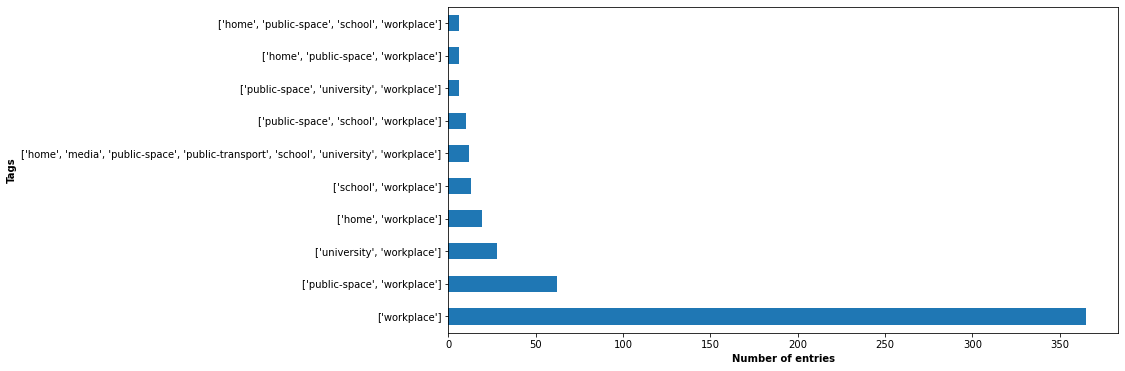

In [8]:
plt.figure()
df['tags'].value_counts()[:10].plot(kind='barh', figsize=(12,6))
plt.xlabel('Number of entries', weight='bold')
plt.ylabel('Tags', weight='bold')

The plot below shows the distribution of 'workplace' entries submitted from Sep 2019 to Sep 2022 (no submissions from sept 2019-feb 2020). There are no noticeable trends.

Text(0, 0.5, '(year, month)')

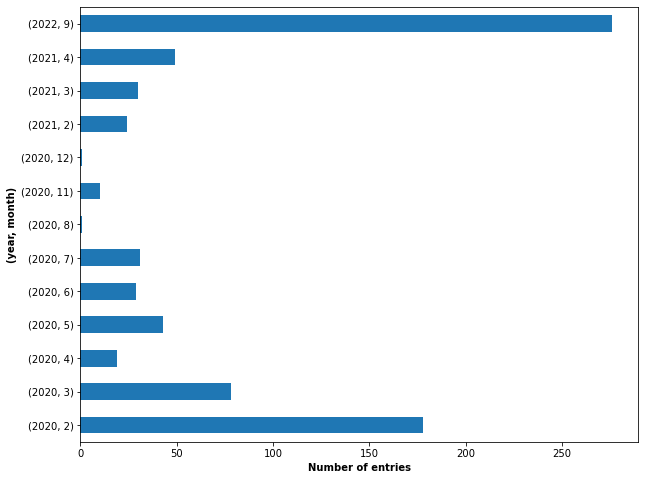

In [9]:
#df.groupby([df['month'], df['year']])['description'].sort_values(['month','year'])
#df.sort_values(['month', 'year'])
plt.figure(figsize=(10,8))
df.groupby([df['year'], df['month']])['description'].count().plot(kind='barh')
plt.xlabel('Number of entries', weight='bold')
plt.ylabel('(year, month)', weight='bold')


# Exploratory NLP

In [10]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
import re

### Let's do a crude preprocessing and cleaning of the text data first

In [11]:
# strip puncutation
df['ProcessedText'] = df['description'].map(lambda x: re.sub('[,\.!?]', '', x))
df.head()

# convert all to lower case
df['ProcessedText'] = df['ProcessedText'].map(lambda x: x.lower())
df.head()


,post_id,tags,description,DATETIME,month,year,ProcessedText
0,post-199274,"['university', 'workplace']","Hello Laura, Thank you so much for creating a ...",2022-09-21,9,2022,hello laura thank you so much for creating a s...
1,post-199285,"['conferences', 'engineering', 'webinars', 'wo...","Since lockdowns began over a year ago, I have ...",2022-09-21,9,2022,since lockdowns began over a year ago i have a...
2,post-199299,['workplace'],I work in a library and seeing what passes for...,2022-09-21,9,2022,i work in a library and seeing what passes for...
3,post-199308,['workplace'],Nothing quite like the review of being “hard t...,2022-09-21,9,2022,nothing quite like the review of being “hard t...
4,post-199309,['workplace'],I’m a finance manager – oversee millions of do...,2022-09-21,9,2022,i’m a finance manager – oversee millions of do...


Let's create a word cloud of all entries from Sep 2019 to Sep 2022.
(be sure to install wordcloud first using `pip install wordcloud` or `conda install -c conda-forge wordcloud`)

(-0.5, 399.5, 199.5, -0.5)

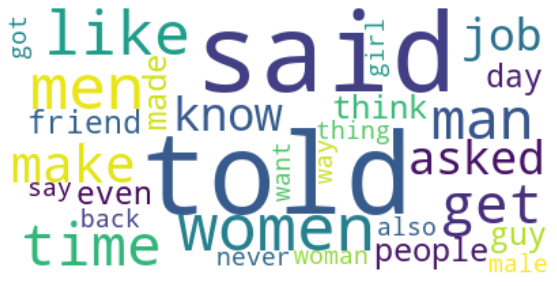

In [12]:
alltext = ' '.join(df['ProcessedText'])
excludeWords = ['work', \
                'would', \
                'could', \
                'one',  \
                ]
newText = alltext
for word in excludeWords:
    newText = newText.replace(word, '')

stopwordsSet = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stopwordsSet, max_words=30, collocations=True, background_color='white',).generate(newText)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [13]:
wordcloud.words_.keys()

dict_keys(['told', 'said', 'women', 'men', 'like', 'time', 'man', 'get', 'make', 'asked', 'know', 'job', 'people', 'think', 'made', 'even', 'friend', 'day', 'guy', 'thing', 'got', 'never', 'also', 'woman', 'want', 'back', 'say', 'way', 'girl', 'male'])

### **The above wordcloud doesn't tell us much information as it doesn't show much of the context or topics. We shall do a more thorough clean up and further topic modelling to get better insights.**

# Topic modelling using LDA

Linear Dirichlet Allocation (DLA) in the context of natural language processing is a type of modelling that can be used to make observations of similar distribution of topics/words. The general assumption is that each entry (document) comprises a mixture of topics. And each topic is a mixture of words (tokens).

To perform LDA, we'll use the gensim package. First install using `pip install gensim` or `conda install -c conda-forge gensim`)

In [14]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS  # we'll use a bigger library of STOPWORDS from gensim instead of nltk
import gensim.corpora as corpora
import nltk
import ast # used in lemmatize function

### Preprocessing for LDA

In [15]:
# define functions for preprocessing

# break into tokens and deaccent, will convert to lowercase, ignoring tokens that are too short or too long
def tokenizeAndDeaccent(sentences):
    '''
    Uses gensim simple_preprocess method to deaccent, convert to lower case text, and tokenize sentences.

    :param sentences    : list of str, where is each story entry is a list itself.
    :yield              : generator object
    '''
    for sentence in sentences:
        yield(simple_preprocess(str(sentence),deacc=True))

# remove stop words
def removeStopWords(text, stopWords):
    '''
    Remove stopwords in text.

    :param text         : list of list of str, where is each string element is an entry/story.
    :param stopWords    : list of str, list of stopwords
    :return             : list of list of str
    '''
    # return [[word for word in simple_preprocess(str(entry)) if word not in stopWords] for entry in text]
    return [[word for word in entry if word not in stopWords] for entry in text]

# stemming  
def stem(text):
    '''
    Lemmatize text using gensim's porterstemmer to  - reduce the text to its common base form. For example, car,cars -> car.

    :param text         : list of list of str, where is each story entry is a list itself.
    :return             : list of list of str
    '''
    porter = PorterStemmer()
    return ast.literal_eval(porter.stem(str(text)))

# give most common words
def findFreqDist(text, k):
    '''
    Obtain top k common words in text using nltk freqdist.

    :param text         : list of list of str, where is each story entry is a list itself.
    :param k            : number of k top words
    :return             : list of list of str
    '''

    fdist = nltk.FreqDist([item for sublist in text for item in sublist])
    topCommonWords = [i[0] for i in fdist.most_common(k)]
    return topCommonWords


In [16]:
# grab text
textData = df['description'].values.tolist()

In [17]:
# clean the text

tokens = tokenizeAndDeaccent(textData)

tokenList = list(tokens)
type(tokenList)

list

**Manual inspection of words needed here to set k value**

In [18]:
# obtain top k most frequent words from the text
k=300

topCommonWords = findFreqDist([i.split(' ') for i in textData],k)

# inspect common words to see if it's reasonable to filter off
print(topCommonWords)

['I', 'and', 'to', 'the', 'a', 'was', 'my', 'of', 'in', 'that', 'me', 'he', 'it', 'for', 'with', 'at', 'on', 'have', 'as', 'is', 'had', 'this', 'not', 'but', 'him', 'about', 'his', 'be', 'so', 'they', 'when', 'just', 'He', 'work', 'or', 'because', 'would', 'told', 'said', 'one', 'who', 'like', 'you', 'by', 'up', 'were', 'all', 'an', 'I’m', 'from', 'if', 'are', 'we', 'out', 'am', 'male', 'didn’t', 'do', 'The', 'what', 'i', 'women', 'how', 'get', 'men', '–', 'being', 'been', 'me.', 'man', 'time', 'no', 'them', 'asked', 'more', 'only', 'other', 'then', 'even', 'made', 'there', 'very', 'could', 'It', 'feel', 'their', 'don’t', 'When', 'know', 'has', 'got', 'think', 'some', 'never', 'back', 'felt', 'My', 'people', 'make', 'started', 'did', 'after', 'went', 'female', 'over', 'say', 'really', 'her', 'which', 'years', 'also', 'me,', 'she', 'than', 'where', 'should', 'job', 'want', 'still', 'our', 'it.', 'I’ve', 'into', 'it’s', 'can', 'This', 'thought', 'manager', 'day', 'any', 'working', 'woman

Out of the k number of common words, we will not filter off some of them as the can have some context

In [19]:
retainList = ['colleague', 'boss', 'sexual', 'colleagues', 'office', 'manager', 'friend', 'comments', 'friends', 'sexism',
'staff', 'company', 'experience', 'night', 'sexist', 'point', 'help', 'uncomfortable', 'harassment', 'meeting']

topCommonWordsToFilter = [word for word in topCommonWords if word not in retainList]
print(topCommonWordsToFilter)

['I', 'and', 'to', 'the', 'a', 'was', 'my', 'of', 'in', 'that', 'me', 'he', 'it', 'for', 'with', 'at', 'on', 'have', 'as', 'is', 'had', 'this', 'not', 'but', 'him', 'about', 'his', 'be', 'so', 'they', 'when', 'just', 'He', 'work', 'or', 'because', 'would', 'told', 'said', 'one', 'who', 'like', 'you', 'by', 'up', 'were', 'all', 'an', 'I’m', 'from', 'if', 'are', 'we', 'out', 'am', 'male', 'didn’t', 'do', 'The', 'what', 'i', 'women', 'how', 'get', 'men', '–', 'being', 'been', 'me.', 'man', 'time', 'no', 'them', 'asked', 'more', 'only', 'other', 'then', 'even', 'made', 'there', 'very', 'could', 'It', 'feel', 'their', 'don’t', 'When', 'know', 'has', 'got', 'think', 'some', 'never', 'back', 'felt', 'My', 'people', 'make', 'started', 'did', 'after', 'went', 'female', 'over', 'say', 'really', 'her', 'which', 'years', 'also', 'me,', 'she', 'than', 'where', 'should', 'job', 'want', 'still', 'our', 'it.', 'I’ve', 'into', 'it’s', 'can', 'This', 'thought', 'day', 'any', 'working', 'woman', 'first',

In [20]:
# use standard stopwords from gensim
stopWords = list(STOPWORDS)
len(stopWords)

# filter off more common words
stopWords.extend(topCommonWordsToFilter)
print(stopWords)

['everywhere', 'nine', 'thus', 'an', 'always', 'full', 'de', 'had', 'whether', 'as', 'somehow', 'once', 'bottom', 'km', 'used', 'further', 'none', 'well', 'ours', 'thereafter', 'seem', 'whole', 'from', 'us', 'another', 'wherever', 'become', 'will', 'somewhere', 'serious', 'four', 'nothing', 'with', 'either', 'describe', 'therefore', 'after', 'along', 'for', 'computer', 'five', 'back', 'own', 'although', 'would', 'hereby', 'eight', 'two', 'you', 'third', 'whom', 'still', 'under', 'everyone', 'these', 'no', 'what', 'something', 'others', 'didn', 'con', 'while', 'hereafter', 'make', 'amoungst', 'herself', 'cant', 'into', 'whereby', 'less', 'alone', 'get', 'un', 'doing', 'thin', 'we', 'neither', 'anyway', 'namely', 'why', 'couldnt', 'both', 'cry', 'nor', 'done', 'detail', 'yourself', 'among', 'your', 'down', 'fifty', 'where', 'sixty', 'side', 'take', 'mill', 'around', 'its', 'itself', 'seems', 'several', 'rather', 'ie', 'whereas', 'various', 'even', 'empty', 'being', 'anything', 'himself',

In [21]:
# remove stop words
tokenNoStopWords = removeStopWords(tokenList, stopWords)  
#print(tokenNoStopWords)

In [22]:
type(tokenNoStopWords)

list

In [23]:
# perform stemming
tokenNoStopWordsStemed = stem(tokenNoStopWords)

# peform lemmatization
nltk.download('wordnet')
lemmaObj = nltk.wordnet.WordNetLemmatizer()

tokenNoStopWordsStemLem = [[lemmaObj.lemmatize(word) for word in entry] for entry in tokenNoStopWordsStemed]
# print(tokenNoStopWordsStemLem)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/franciscatan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# check n top common words again, second pass
n = 50
print(findFreqDist(tokenNoStopWordsStemLem, n))


['colleague', 'friend', 'manager', 've', 'comment', 'bos', 'office', 'sexism', 'experience', 'sexual', 'wasn', 'uncomfortable', 'week', 'company', 'meeting', 'joke', 'girl', 'staff', 'story', 'help', 'sexist', 'point', 'place', 'month', 'age', 'night', 'member', 'couldn', 'workplace', 'boyfriend', 'body', 'customer', 'harassment', 'behaviour', 'child', 'angry', 'better', 'wrong', 'face', 'bad', 'today', 'nice', 'husband', 'laughed', 'student', 'feeling', 'end', 'idea', 'car', 'word']


Upon inspection of the top common words again, we'll exlude some that make sense to. 

In [25]:
# commonWordsSecondPass = ['day', 'thing', 'guy', 'woman', 'girl', 've', 'way', \
#                         'boy', 'working', 'old', 'wanted', 'good', 'going', \
#                         'life', 'year', 'tell', 'came', 'come', 'worked', \
#                         'new', 'left', 'saying', 'wasn', \
#                         'week', 'let', 'need', 'time']

commonWordsSecondPass = ['ve', 'wasn', 'girl', 'couldn']

In [26]:
# remove common words again
cleanTextPassed = str([item for item in tokenNoStopWordsStemLem if item not in commonWordsSecondPass])

In [27]:
# further filtering of common words
newtokens = []
for tok in tokenNoStopWordsStemLem:
   newtokens.append(list(filter(lambda x: x not in commonWordsSecondPass, tok)))

# double check that filtering worked
print(findFreqDist(newtokens,30))

['colleague', 'friend', 'manager', 'comment', 'bos', 'office', 'sexism', 'experience', 'sexual', 'uncomfortable', 'week', 'company', 'meeting', 'joke', 'staff', 'story', 'help', 'sexist', 'point', 'place', 'month', 'age', 'night', 'member', 'workplace', 'boyfriend', 'body', 'customer', 'harassment', 'behaviour']


In [28]:
# build corpus

cleanTokenList = newtokens

wordID = corpora.Dictionary(cleanTokenList)
#list(corpusDict)

corpus = [wordID.doc2bow(tokenList) for tokenList in cleanTokenList]


In [29]:
len(corpus)

769

### LDA modelling

One caveat about LDA modelling is that it requires the user to decide on the number of topics. We'll use some simple metrics like perplexity and coherence to decide what the ideal number of topics would be.

The perplexity gives a measure tells how well the model predicts (predictive likelihood). Gensim libraries can calculate perplexity, it would be in negative sign because it's a log of the number. So for example, -1 is better than -2. However, some studies shows that perplexity is not offen correlated with human judgement of topics. See https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 

The coherence score measures how interpretable the topic would be - it measures how similar the words in the topics are to each other.
Some information on types of coherence scores: https://www.baeldung.com/cs/topic-modeling-coherence-score

In [30]:
perplexityList = []
coherenceList = []
maxNumTopics = 70

for numTopics in range(1,maxNumTopics+1):
    print('numTopics = ' + str(numTopics))

    #build LDA model
    lda = gensim.models.LdaModel(corpus=corpus, id2word=wordID,num_topics=numTopics, \
                passes=4, alpha=[0.01]*numTopics, eta=[0.01]*len(wordID.keys()))  #, \
            #  iterations=50, chunksize=100, eval_every=None, random_state=0)

    # # print keywords per topic
    # for i,topic in lda.show_topics(formatted=True, num_topics=numTopics, num_words=10):
    #     print(str(i)+": "+ topic)

    # calculate perplexity and coherence score
    perplexityScore = lda.log_perplexity(corpus)
    # {u_mass', 'c_v', 'c_uci', 'c_npmi'}
    coherenceScoreLda = gensim.models.CoherenceModel(model=lda, texts=cleanTokenList, dictionary=wordID, coherence='c_v')  #conda install -c conda-forge python-levenshtein
    coherenceScore = coherenceScoreLda.get_coherence()
    
    # print('Perplexity:', perplexityScore)
    # print('Coherence Score:', coherenceScore)

    perplexityList.append(perplexityScore)
    coherenceList.append(coherenceScore)

numTopics = 1
numTopics = 2
numTopics = 3
numTopics = 4
numTopics = 5
numTopics = 6
numTopics = 7
numTopics = 8
numTopics = 9
numTopics = 10
numTopics = 11
numTopics = 12
numTopics = 13
numTopics = 14
numTopics = 15
numTopics = 16
numTopics = 17
numTopics = 18
numTopics = 19
numTopics = 20
numTopics = 21
numTopics = 22
numTopics = 23
numTopics = 24
numTopics = 25
numTopics = 26
numTopics = 27
numTopics = 28
numTopics = 29
numTopics = 30
numTopics = 31
numTopics = 32
numTopics = 33
numTopics = 34
numTopics = 35
numTopics = 36
numTopics = 37
numTopics = 38
numTopics = 39
numTopics = 40
numTopics = 41
numTopics = 42
numTopics = 43
numTopics = 44
numTopics = 45
numTopics = 46
numTopics = 47
numTopics = 48
numTopics = 49
numTopics = 50
numTopics = 51
numTopics = 52
numTopics = 53
numTopics = 54
numTopics = 55
numTopics = 56
numTopics = 57
numTopics = 58
numTopics = 59
numTopics = 60
numTopics = 61
numTopics = 62
numTopics = 63
numTopics = 64
numTopics = 65
numTopics = 66
numTopics = 67
numT

In [33]:
len(perplexityList)

70

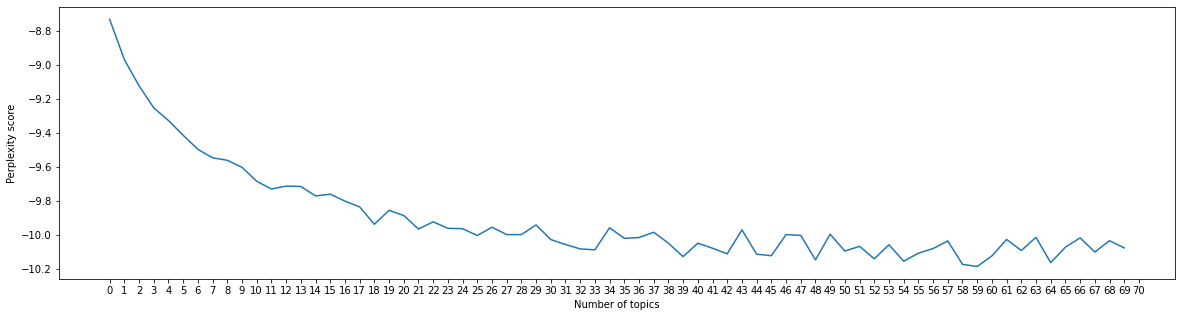

In [46]:
plt.figure(figsize=(20,5))
ax = plt.plot(perplexityList)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity score')
plt.xticks(ticks=range(0,maxNumTopics+1))
plt.show() # to supress output text

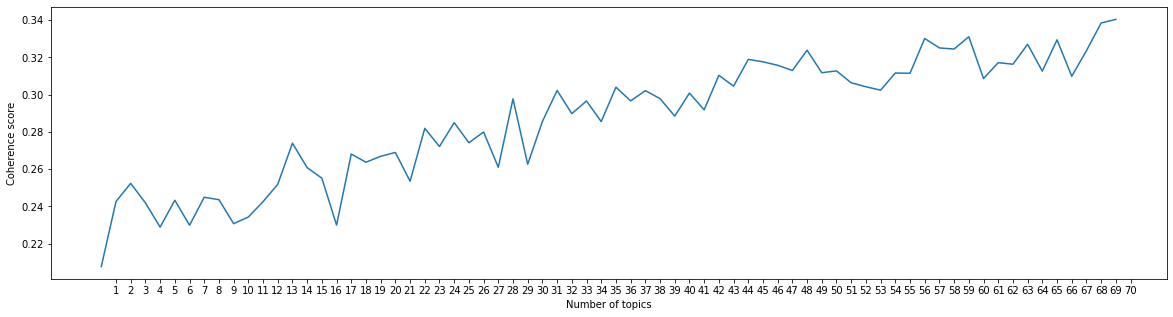

In [47]:
plt.figure(figsize=(20,5))
ax = plt.plot(coherenceList)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.xticks(range(1,maxNumTopics+1))
plt.show() # to supress output text

Choose an n number of the appropriate number of topics based on the graphs above, and rebuild the model based on that number

In [48]:
# set numTopics to be the ideal number
numTopics = 55

lda = gensim.models.LdaModel(corpus=corpus, id2word=wordID,num_topics=numTopics, \
                passes=4, alpha=[0.01]*numTopics, eta=[0.01]*len(wordID.keys()))  #, \
            #  iterations=50, chunksize=100, eval_every=None, random_state=0)

perplexityScore = lda.log_perplexity(corpus)
# {u_mass', 'c_v', 'c_uci', 'c_npmi'}
coherenceScoreLda = gensim.models.CoherenceModel(model=lda, texts=cleanTokenList, dictionary=wordID, coherence='c_v') 
coherenceScore = coherenceScoreLda.get_coherence()
    
print('Perplexity:', perplexityScore)
print('Coherence Score:', coherenceScore)

Perplexity: -9.994263436148138
Coherence Score: 0.32129910629509345


To visualise LDA, we'll use pyldavis. First install using `pip install pyldavis` or `conda install -c conda-forge pyldavis`)

In [49]:
# visualize LDA
import pyLDAvis
import pyLDAvis.gensim_models as ldavis
from jupyterthemes import jtplot  #conda install -c conda-forge jupyterthemes

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [50]:
vis = ldavis.prepare(topic_model=lda, corpus=corpus, dictionary=wordID)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)


/Users/franciscatan/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/franciscatan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/franciscatan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/franciscatan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/francis

### Assign topic number back to document

In [51]:
# grab topic number and probabiliy from the lda model and put them in a dataframe
topics = [lda[corpus[entry]][0] for entry in range(len(df))]
topicFrame = pd.DataFrame(topics, columns=['Topic Number', 'LDA Probability Score'])
topicFrame.tail()

,Topic Number,LDA Probability Score
764,35,0.981723
765,21,0.989316
766,48,0.978863
767,19,0.956967
768,2,0.990450


In [52]:
topicFrame['LDA Probability Score'].describe()

count    769.000000
mean       0.904120
std        0.227693
min        0.011435
25%        0.965267
50%        0.981723
75%        0.989524
max        0.998128
Name: LDA Probability Score, dtype: float64

From the above description, the mean probability is pretty good.
Let's plot the distribution of topics based on the entries in the dataset.

Text(0, 0.5, 'Number of documents')

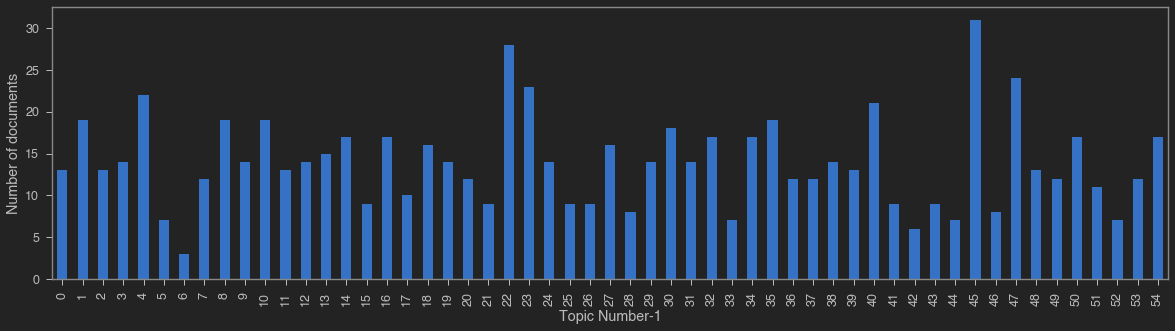

In [53]:
plt.figure()
topicFrame['Topic Number'].value_counts().sort_index().plot(kind='bar', figsize=(20,5))
plt.xlabel('Topic Number-1')
plt.ylabel('Number of documents')

In [54]:
# grab word features for each topic number and put them in a dataframe

topicFeatureFrame = pd.DataFrame(lda.show_topics(num_topics=numTopics, num_words=10), columns=['Topic Number','Feature Words'])
topicFeatureFrame['Topic Number'] = topicFeatureFrame['Topic Number'].apply(lambda x: x+1)
topicFeatureFrame.tail()

,Topic Number,Feature Words
50,51,"0.011*""colleague"" + 0.010*""bos"" + 0.008*""comme..."
51,52,"0.009*""manager"" + 0.009*""sexual"" + 0.008*""fiel..."
52,53,"0.017*""bed"" + 0.009*""manager"" + 0.009*""gave"" +..."
53,54,"0.012*""experience"" + 0.011*""manager"" + 0.009*""..."
54,55,"0.010*""manager"" + 0.007*""business"" + 0.007*""se..."


### What are the top 5 most 'coherent' topics?

In [55]:
# Grab all top topics from LDA model
# lda.top_topics(corpus, topn=10)[0][0]
topTopics = lda.top_topics(corpus, topn=10)
len(topTopics)

55

In [56]:
# Remap tuples to dict so that wordcloud function accepts it, do for top n topics
n = 5
topTopics = [{wordFeature:freq for freq, wordFeature in lda.top_topics(corpus, topn=10)[topic][0]} for topic in range(n)]
topTopics[0]

{'husband': 0.008854658,
 'office': 0.0087749185,
 'age': 0.0069150925,
 'mistake': 0.00535863,
 'colleague': 0.004949298,
 'week': 0.0047818385,
 'child': 0.0046107406,
 'experience': 0.004468087,
 'help': 0.004408024,
 'understand': 0.0043591163}

/var/folders/gh/cyykbpd16fj4_f_f7h8m48f00000gn/T/ipykernel_68344/3879741040.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot((len(topTopics)/2+1), 2, i+1)


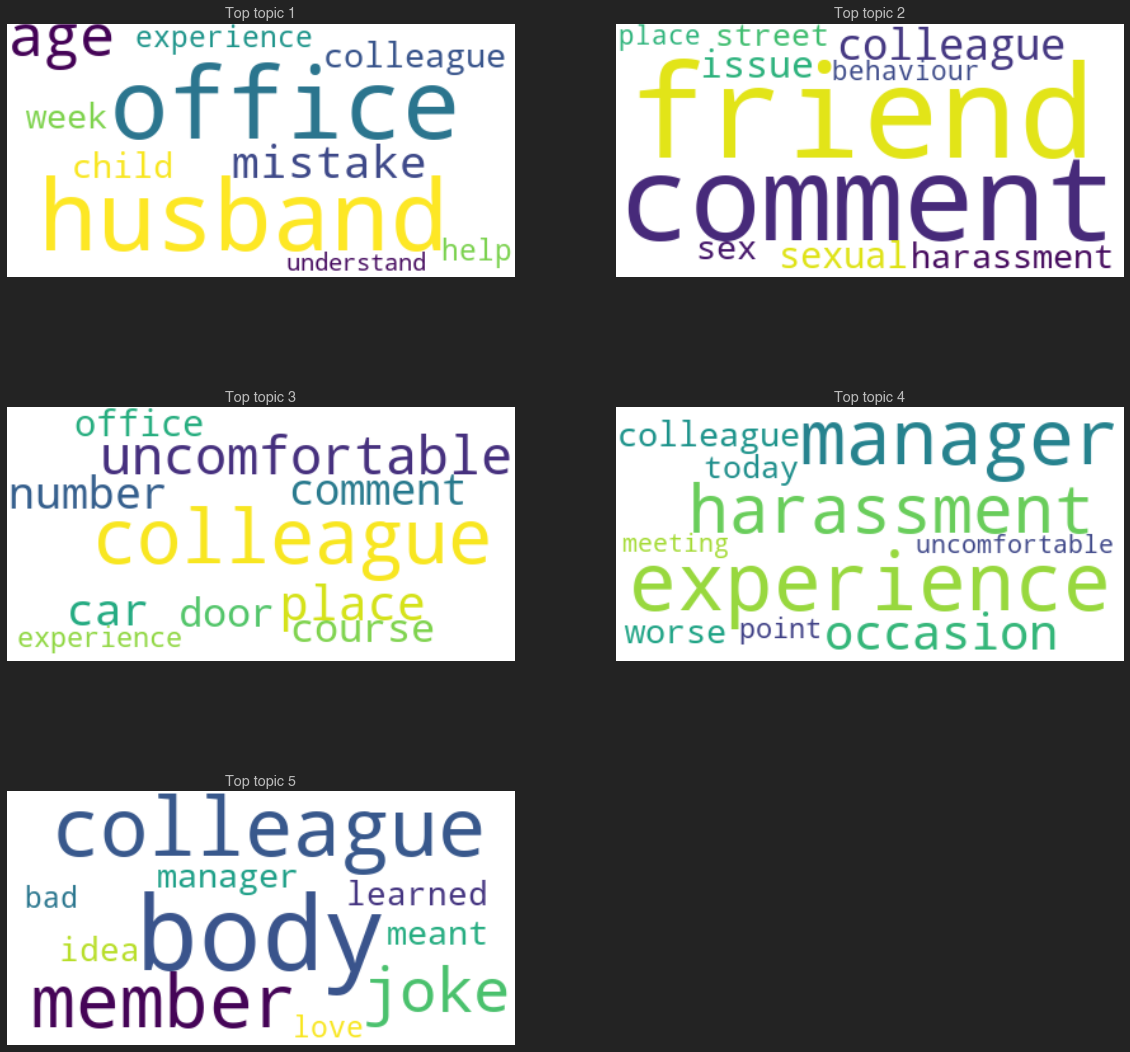

In [57]:
# wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
plt.figure(figsize=(20,20))
wordcloud = WordCloud(prefer_horizontal=1, background_color='white')

for i in range(len(topTopics)):
    wordcloud.generate_from_frequencies(frequencies=topTopics[i])
    plt.subplot((len(topTopics)/2+1), 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Top topic ' + str(i+1))

plt.show()

There are other ways that can be further explored to fine tune the LDA model - for example:
- further cleaning or filtering by choosing noun and/or verbs and/or adjectives
- changing the LDA learning parameters
- keeping phrases (bigram/trigram)

### Helpful references:
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- https://www.kdnuggets.com/2019/09/overview-topics-extraction-python-latent-dirichlet-allocation.html
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

